In [1]:
# Installing necessary modules.

!pip install -r requirements.txt

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
import re
import contractions
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/farazahmed/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/farazahmed/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/farazahmed/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/farazahmed/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
data = pd.read_csv('flipitnews-data.csv')
data.head()

,Category,Article
0,Technology,tv future in the hands of viewers with home th...
1,Business,worldcom boss left books alone former worldc...
2,Sports,tigers wary of farrell gamble leicester say ...
3,Sports,yeading face newcastle in fa cup premiership s...
4,Entertainment,ocean s twelve raids box office ocean s twelve...


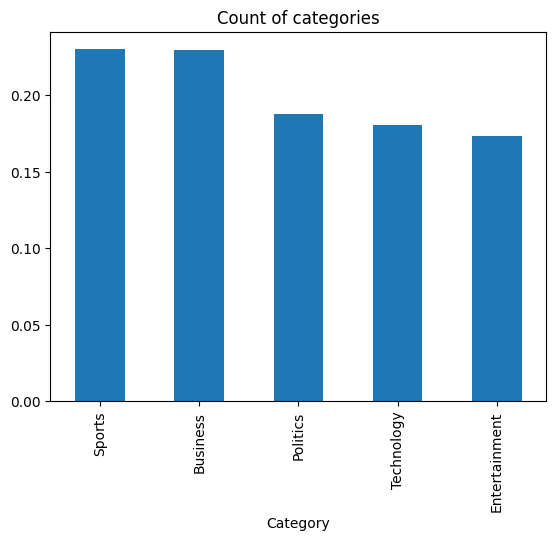

In [4]:
# Count of categories.

data['Category'].value_counts(normalize=True).plot(kind='bar', title='Count of categories')
plt.show()

In [5]:
data['Article'].iloc[0]

'tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are also being built-in to high

In [6]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """
    Preprocess the text by removing non-letters, converting to lowercase,
    expanding contractions, removing stop words, and lemmatizing.
    """

# Convert to lowercase
    text = text.lower()

# Expand contractions
    text = contractions.fix(text)

# Remove non-letters
    text = re.sub("[^a-zA-Z]", " ", text)

# Tokenize the text
    words = word_tokenize(text)

# Remove stop words and lemmatize
    cleaned_words = [lemmatizer.lemmatize(words) for words in words if words not in stop_words]

    return ' '.join(cleaned_words)

In [7]:
sample_index = 100
print("Original Article:\n", data['Article'][sample_index])
print("\nProcessed Article:\n", preprocess_text(data['Article'][sample_index]))

Original Article:
 housewives lift channel 4 ratings the debut of us television hit desperate housewives has helped lift channel 4 s january audience share by 12% compared to last year.  other successes such as celebrity big brother and the simpsons have enabled the broadcaster to surpass bbc two for the first month since last july. bbc two s share of the audience fell from 11.2% to 9.6% last month in comparison with january 2004. celebrity big brother attracted fewer viewers than its 2002 series.  comedy drama desperate housewives managed to pull in five million viewers at one point during its run to date  attracting a quarter of the television audience. the two main television channels  bbc1 and itv1  have both seen their monthly audience share decline in a year on year comparison for january  while five s proportion remained the same at a slender 6.3%. digital multi-channel tv is continuing to be the strongest area of growth  with the bbc reporting freeview box ownership of five mil

In [8]:
data['Processed_Article'] = data['Article'].apply(preprocess_text)
data.head()

,Category,Article,Processed_Article
0,Technology,tv future in the hands of viewers with home th...,tv future hand viewer home theatre system plas...
1,Business,worldcom boss left books alone former worldc...,worldcom bos left book alone former worldcom b...
2,Sports,tigers wary of farrell gamble leicester say ...,tiger wary farrell gamble leicester say rushed...
3,Sports,yeading face newcastle in fa cup premiership s...,yeading face newcastle fa cup premiership side...
4,Entertainment,ocean s twelve raids box office ocean s twelve...,ocean twelve raid box office ocean twelve crim...


In [10]:
label_encoder = LabelEncoder()
data['Encoded_Category'] = label_encoder.fit_transform(data['Category'])

# See the mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Category Encoding Mapping:\n", label_mapping)

Category Encoding Mapping:
 {'Business': np.int64(0), 'Entertainment': np.int64(1), 'Politics': np.int64(2), 'Sports': np.int64(3), 'Technology': np.int64(4)}


In [11]:
data.head()

,Category,Article,Processed_Article,Encoded_Category
0,Technology,tv future in the hands of viewers with home th...,tv future hand viewer home theatre system plas...,4
1,Business,worldcom boss left books alone former worldc...,worldcom bos left book alone former worldcom b...,0
2,Sports,tigers wary of farrell gamble leicester say ...,tiger wary farrell gamble leicester say rushed...,3
3,Sports,yeading face newcastle in fa cup premiership s...,yeading face newcastle fa cup premiership side...,3
4,Entertainment,ocean s twelve raids box office ocean s twelve...,ocean twelve raid box office ocean twelve crim...,1


In [12]:
def vectorize_text(data, method="bow"):
    """Vectorize the text data using either Bag of Words or TF-IDF.
    Args:
        data (pd.DataFrame): DataFrame containing the text data.
        method (str): Method for vectorization ('bow' or 'tfidf').
    Returns:
        X (sparse matrix): Vectorized text data.
        vectorizer: The vectorizer used for transformation.
    """
    if method == "bow":
        vectorizer = CountVectorizer()
    elif method == "tfidf":
        vectorizer = TfidfVectorizer()
    else:
        raise ValueError("Method must be either 'bow' or 'tfidf'")

    X = vectorizer.fit_transform(data["Processed_Article"])
    return X, vectorizer

In [15]:
X, vectorizer = vectorize_text(data, method="tfidf")  # or method='bow'
y = data["Encoded_Category"]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [17]:
# Train a Naive Bayes model

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred = nb_model.predict(X_test)

Classification Report:
                precision    recall  f1-score   support

     Business       0.94      0.95      0.95       101
Entertainment       1.00      0.89      0.94        81
     Politics       0.92      0.98      0.95        83
       Sports       0.99      1.00      0.99        98
   Technology       0.95      0.98      0.96        82

     accuracy                           0.96       445
    macro avg       0.96      0.96      0.96       445
 weighted avg       0.96      0.96      0.96       445



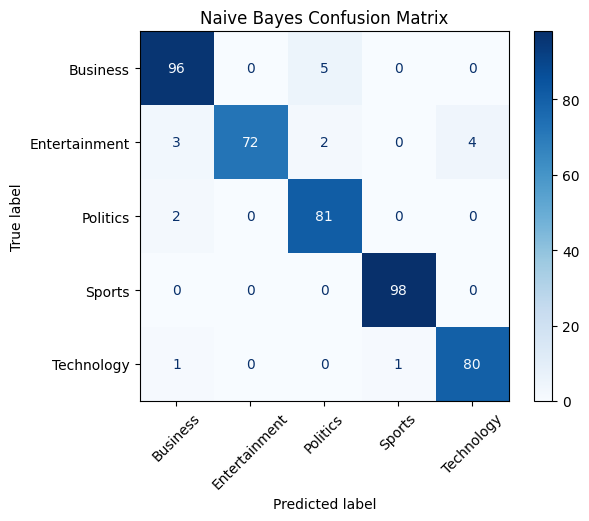

In [18]:
print(
    "Classification Report:\n",
    classification_report(y_test, y_pred, target_names=label_encoder.classes_),
)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=label_encoder.classes_
)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Naive Bayes Confusion Matrix")
plt.show()

In [19]:
def train_and_evaluate_model(
    model, X_train, X_test, y_train, y_test, model_name="Model"
):
    """
    Train and evaluate a model, printing the classification report and confusion matrix.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n {model_name} - Classification Report")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=label_encoder.classes_
    )
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()


 Decision Tree - Classification Report
               precision    recall  f1-score   support

     Business       0.76      0.78      0.77       101
Entertainment       0.90      0.75      0.82        81
     Politics       0.80      0.84      0.82        83
       Sports       0.91      0.88      0.90        98
   Technology       0.79      0.88      0.83        82

     accuracy                           0.83       445
    macro avg       0.83      0.83      0.83       445
 weighted avg       0.83      0.83      0.83       445



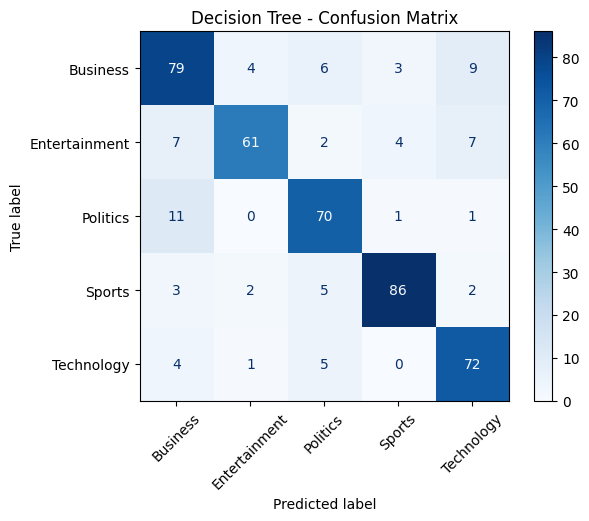


 K-Nearest Neighbors - Classification Report
               precision    recall  f1-score   support

     Business       0.94      0.86      0.90       101
Entertainment       0.97      0.95      0.96        81
     Politics       0.86      0.90      0.88        83
       Sports       0.97      1.00      0.98        98
   Technology       0.95      0.99      0.97        82

     accuracy                           0.94       445
    macro avg       0.94      0.94      0.94       445
 weighted avg       0.94      0.94      0.94       445



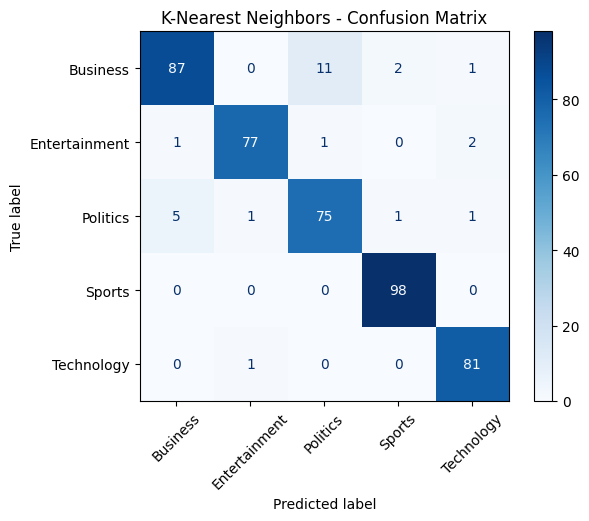


 Random Forest - Classification Report
               precision    recall  f1-score   support

     Business       0.91      0.96      0.93       101
Entertainment       1.00      0.93      0.96        81
     Politics       0.95      0.94      0.95        83
       Sports       0.98      0.99      0.98        98
   Technology       0.96      0.96      0.96        82

     accuracy                           0.96       445
    macro avg       0.96      0.96      0.96       445
 weighted avg       0.96      0.96      0.96       445



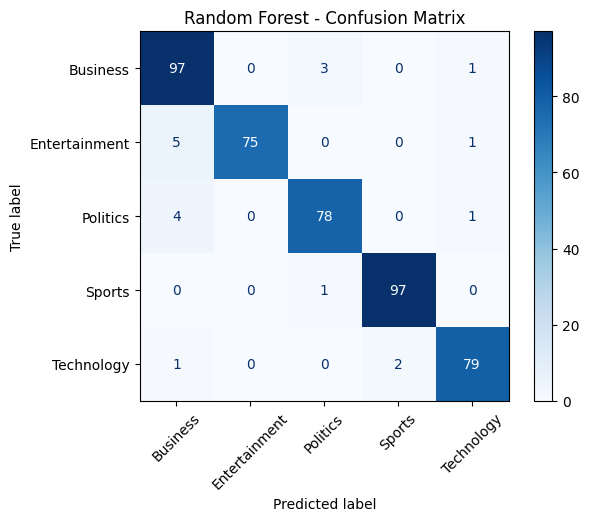

In [20]:
# 1. Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
train_and_evaluate_model(
    dt_model, X_train, X_test, y_train, y_test, model_name="Decision Tree"
)

# 2. K-Nearest Neighbors
knn_model = KNeighborsClassifier(n_neighbors=5)
train_and_evaluate_model(
    knn_model, X_train, X_test, y_train, y_test, model_name="K-Nearest Neighbors"
)

# 3. Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
train_and_evaluate_model(
    rf_model, X_train, X_test, y_train, y_test, model_name="Random Forest"
)

In [21]:
def get_model_scores(model, X_train, X_test, y_train, y_test):
    """Train the model and return accuracy and F1-score."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1-Score (Macro)": f1_score(y_test, y_pred, average="macro"),
    }


In [22]:
models = {
    "Naive Bayes": MultinomialNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
}

results = {}

for name, model in models.items():
    scores = get_model_scores(model, X_train, X_test, y_train, y_test)
    results[name] = scores

# Convert to DataFrame for nice display
results_df = pd.DataFrame(results).T.sort_values(by="F1-Score (Macro)", ascending=False)
print("\n Model Comparison:\n")
print(results_df)


 Model Comparison:

                     Accuracy  F1-Score (Macro)
Naive Bayes          0.959551          0.958627
Random Forest        0.957303          0.957574
K-Nearest Neighbors  0.939326          0.939349
Decision Tree        0.826966          0.827288


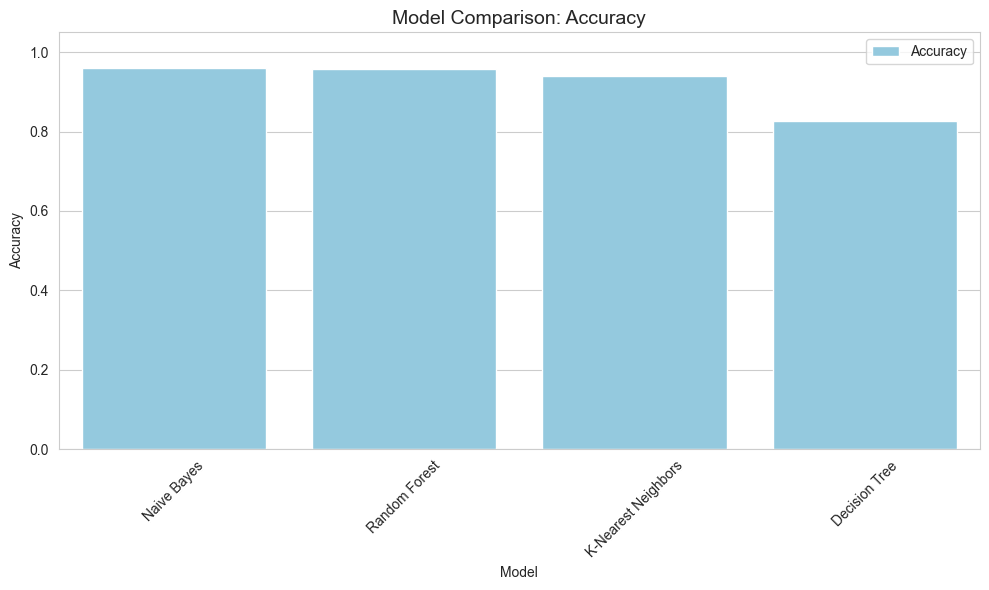

In [23]:
# Reset index for plotting
results_df_plot = results_df.reset_index().rename(columns={"index": "Model"})

# Plot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Accuracy bar
sns.barplot(
    data=results_df_plot, x="Model", y="Accuracy", color="skyblue", label="Accuracy"
)

plt.title("Model Comparison: Accuracy", fontsize=14)
plt.xticks(rotation=45)
plt.ylim(0, 1.05)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

#### We can see above that the Naive Bayes and Random Forest models outperform the others.